In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as td
import numpy as np
import os
import random
from PIL import Image
from scripts.unet_model import *
from scripts.indices import *

In [2]:
image_dir = '/application/pi/Desktop/all imp data/Unet_training/images/'
mask_dir = '/application/pi/Desktop/all imp data/Unet_training/masks/'

In [3]:
class PlaneDataSet(td.Dataset):
    
    def __init__(self, image_path, mask_path):
        import os
        
        self.image_path = image_path
        
        self.mask_path = mask_path
        c = os.listdir(mask_path)
        c.remove('.ipynb_checkpoints')
        self.filenames = c
        
        self.filenames 
    def __getitem__(self, index):
        
        # Get a random intenger between 1 and 2
        rand = random.randint(0, 2)     
        
        #Load the image
        img_path = os.path.join(self.image_path, self.filenames[index])
        image =  np.load(img_path)
        
        # Make Indices
        image_np = allIndices(image)
        
        # Normalize
        image_np = normalize(image_np)
        #print(image_np.shape)
        # Randomly flip the image half the time
#         if rand > 1:
#             image_pil = Image.fromarray(image_np).transpose(Image.FLIP_LEFT_RIGHT).convert("L")          
#             image_np = np.array(image_pil)
        
        # Add a dimension and convert to a tensor
        #image_np = np.expand_dims(image_np, axis=0)
        image_tensor = torch.Tensor(image_np)
        
        # Now do all the same stuff to the mask image
        mask_path = os.path.join(self.mask_path, self.filenames[index])
        mask =  np.load(mask_path)
        #mask_np = mask
        mask_np = np.expand_dims(mask, axis=0)
        mask_tensor = torch.Tensor(mask_np)
        
        return(image_tensor, mask_tensor)
    
    def __len__(self):
        return len(self.filenames)

In [4]:
def load_data(image_path, mask_path):

    # Load all of the images, transforming them
    dataset = PlaneDataSet(image_path , mask_path)
    
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    # define a loader for the image data
    image_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=4,
        num_workers=0,
        shuffle=True,
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        num_workers=0,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=4,
        num_workers=0,
        shuffle=True,
    )
    return image_loader, train_loader, test_loader

image_loader, train_loader, test_loader = load_data(image_dir, mask_dir)

In [5]:
type(image_loader.dataset.__getitem__(12))


tuple

In [6]:
print(type(train_loader))
len(train_loader.dataset)


<class 'torch.utils.data.dataloader.DataLoader'>


384

In [7]:
type(test_loader)
len(test_loader.dataset)


96

In [11]:
!wget "https://aka.ms/unet-pt" -O ~/unet.pt

--2020-05-19 17:04:31--  https://aka.ms/unet-pt
Resolving aka.ms (aka.ms)... 104.102.53.13
Connecting to aka.ms (aka.ms)|104.102.53.13|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://onedrive.live.com/download?cid=783D202C58C75CC2&resid=783D202C58C75CC2%21106&authkey=AC-jDrEgK0Phd6E [following]
--2020-05-19 17:04:31--  https://onedrive.live.com/download?cid=783D202C58C75CC2&resid=783D202C58C75CC2%21106&authkey=AC-jDrEgK0Phd6E
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://asm0nq.bn.files.1drv.com/y4mCNiGIl_J1vKQeYxOKkcyGFnAKwaCoC3V6YIOV8wMoVpd9noT6bRzvnD39AtwBJ2Owr-3auTZcUMgIIZhgwza6OIdKfpR91AO88Tv1iyEdD-ael06P9No574XiCVTm4KwrgqHIbQp2i3-vJRPvdG8-AGlyCQZo6U9ANVY-bl6fT_D8y5h5j9ioOSZlGi1jk1JjOrdOC2WcFGnFLQ-ZuK2Eg/unet.pt?download&psid=1 [following]
--2020-05-19 17:04:32-- 

In [16]:
def train(model, device, data_loader, optimizer, epoch):
    
    model.to(device)
    model.train()
    
    train_loss = 0
    print("Epoch:", epoch, "...")
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(data_loader):
        
        
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        print('loss =', loss.item())
        # Backpropagate
        loss.backward()
        optimizer.step()
        print('loss =', loss.item(),' number',batch_idx)
        
    # return average loss for the epoch
    avg_training_loss = train_loss / (batch_idx+1)
    print("\tTraining set: Average loss: {:.6f}".format(avg_training_loss))
    return avg_training_loss


In [17]:
# Create a UNet model
model = UNet(n_channels=20, n_classes = 1)

# Use the best available device (GPU/CPU) for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Load the weights
# home = os.path.expanduser("~")
# weights_file = os.path.join(home, "unet.pt")
#model.load_state_dict(torch.load('/application/pi/unet_trained_new.pt', map_location=device))

# Specify the optimizer and  loss criteria
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_criteria = nn.BCELoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []

epochs = 1
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)

Training on cpu
Epoch: 1 ...
loss = 0.6727059483528137
loss = 0.6727059483528137  number 0
loss = 0.5968011021614075
loss = 0.5968011021614075  number 1
loss = 0.6145889163017273
loss = 0.6145889163017273  number 2
loss = 0.5046488642692566
loss = 0.5046488642692566  number 3
loss = 0.4308028221130371
loss = 0.4308028221130371  number 4
loss = 0.4716370403766632
loss = 0.4716370403766632  number 5
loss = 0.40973228216171265
loss = 0.40973228216171265  number 6
loss = 0.3928646445274353
loss = 0.3928646445274353  number 7
loss = 0.3914265036582947
loss = 0.3914265036582947  number 8
loss = 0.4758860468864441
loss = 0.4758860468864441  number 9
loss = 0.3263248801231384
loss = 0.3263248801231384  number 10
loss = 0.3265174627304077
loss = 0.3265174627304077  number 11
loss = 0.39941489696502686
loss = 0.39941489696502686  number 12
loss = 0.36327168345451355
loss = 0.36327168345451355  number 13
loss = 0.34793248772621155
loss = 0.34793248772621155  number 14
loss = 0.3466339707374573
lo

In [18]:

torch.save(model.state_dict(), '/application/pi/unet_trained_with_indices.pt')

In [10]:
#!conda install matplotlib
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(n_channels=20, n_classes = 1)
model.load_state_dict(torch.load('/application/pi/unet_trained_with_indices.pt', map_location=device))

<All keys matched successfully>

In [12]:
#model(test_loader.dataset[6][0])

In [11]:
model.eval()


UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm

In [ ]:
i = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data1 = data
    target1 = target
    if batch_idx%4 ==0:
        with torch.no_grad():
            output = model(data1)
        a=np.array(output[0])
        b=np.array(target1[0])
        
        np.save('/application/pi/Desktop/all imp data/Unet testing/trial_image_'+str(i)+'.npy',a)
        np.save('/application/pi/Desktop/all imp data/Unet testing/trial_mask_'+str(i)+'.npy',b)
        i = i+1
    print(batch_idx)
    

In [29]:
with torch.no_grad():
        output = model(data1)

In [30]:
a=np.array(output[0])
b=np.array(target1[0])

In [31]:
np.save('trial_image3.npy',a)
np.save('trial_mask3.npy',b)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
a =np.load('trial_image3.npy')
b =np.load('trial_mask3.npy')

In [21]:
b[0].shape

(512, 512)

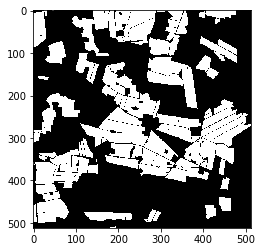

In [22]:
plt.imshow(b[0],cmap ='gray')

In [23]:
a[0].shape

(512, 512)

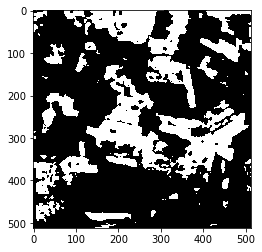

In [25]:
plt.imshow((a[0]>0.2)*1,cmap ='gray')

In [34]:
model2 = UNet(n_channels=20, n_classes = 1)
model2.load_state_dict(torch.load('/application/pi/unet_trained_with_indices.pt', map_location=device))


<All keys matched successfully>